# Random Forest from Scratch

## Imports and Preprocessing

In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [2]:
path = Path("titanic")
df = pd.read_csv(path/"train.csv")
tst_df = pd.read_csv(path/"test.csv")
modes = df.mode().iloc[0]

In [13]:
def proc_data(df):
    # fill nas
    df["Fare"] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    # log + 1 fare
    df["LogFare"] = np.log1p(df["Fare"])

    # tell pandas they are categorical variables
    df["Embarked"] = pd.Categorical(df.Embarked)
    df["Sex"] = pd.Categorical(df.Sex)
    
proc_data(df)
proc_data(tst_df)

In [14]:
cats = ["Sex", "Embarked"]
conts = ["Age", "SibSp", "Parch", "LogFare", "Pclass"]
dep = "Survived"

## Building a Binary Split

/home/ubuntu/miniconda3/envs/fastai/lib/python3.12/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/ubuntu/miniconda3/envs/fastai/lib/python3.12/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


[Text(0.5, 1.0, 'Histogram')]

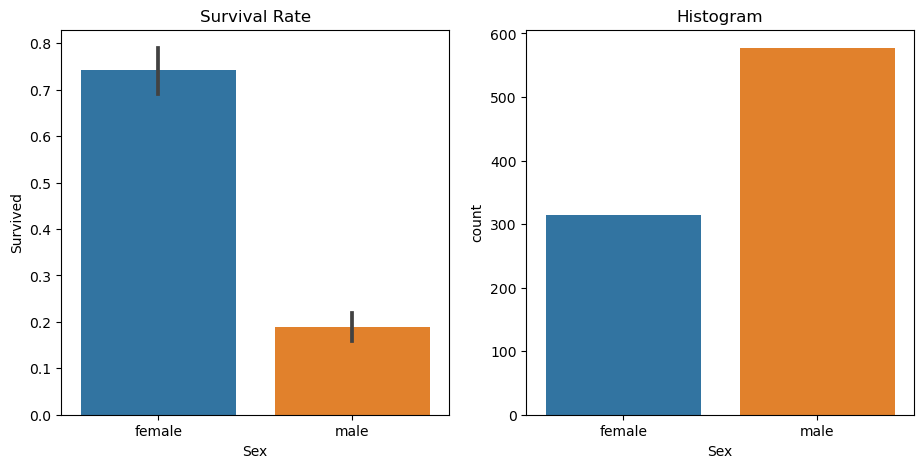

In [23]:
import seaborn as sns
fig, axs, = plt.subplots(1, 2, figsize=(11, 5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival Rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram")

As we can see, this is a reasonable split as both groups are subtantially large *and* there is a pronounced difference in the survivability of members from each group. Lets try a simple model that predicts that males die and females survive.

In [24]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df, val_df = train_test_split(df, test_size=0.25)

# change categorical variables to encoded version for BT
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [28]:
def xs_y(df):
    xs = df[cats + conts].copy()
    return xs, df[dep] if dep in df else None

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

In [29]:
preds = val_xs.Sex == 0

In [31]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

Not a bad result actually, Now we try splitting on a continuous variable.

/home/ubuntu/miniconda3/envs/fastai/lib/python3.12/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/miniconda3/envs/fastai/lib/python3.12/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/miniconda3/envs/fastai/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='LogFare', ylabel='Density'>

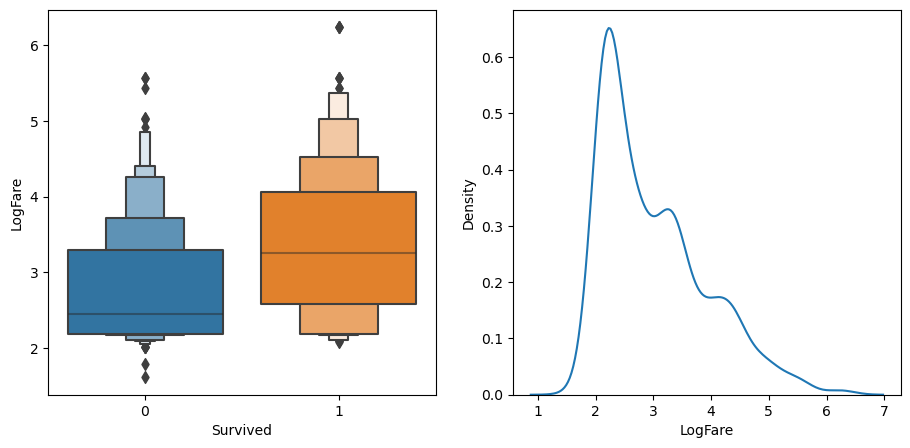

In [35]:
df_fare = trn_df[trn_df.LogFare > 0]
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1])

We can see that the median `LogFare` of those that survuved is about 3.2, whereas that of those who did not was around `2.5`. Hence, with a higher ticket price comes a higher likelihood to survive! We can try predicting those with a `LogFare` of 2.7 or higher as surviving.

In [37]:
preds = val_xs.LogFare > 2.7
mean_absolute_error(val_y, preds)

0.336322869955157

not as good as our `Sex` split. We develop some functionality to help us decide whether a split is any good or not (using both the std dev of the dependent variable and the size of the groups). To score a split we add up the scores for the left and right hand sides of the split.

In [44]:
def _side_score(side, y):
    tot = side.sum()
    if tot <= 1: return 0
    return y[side].std() * tot

def score(col, y, split):
    lhs = col <= split
    return (_side_score(lhs, y) + _side_score(~lhs, y)) / len(y) # normalise

In [45]:
print("Sex Score:", score(trn_xs["Sex"], trn_y, 0.5))
print("LogFare Score:", score(trn_xs["LogFare"], trn_y, 2.7))

Sex Score: 0.4078753098206398
LogFare Score: 0.4718087395209973


In [46]:

nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

6.0

We can programmatically find the best split for a given column by testing each one.

In [47]:
def min_col(df, nm):
    col, y = df[nm], df[dep]
    unq = col.dropna().unique() # only need to test unique value splits
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx], scores[idx]

min_col(trn_df, "Age")

(6.0, 0.47831671750899085)

In [48]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.4078753098206398),
 'Embarked': (0, 0.478833425731479),
 'Age': (6.0, 0.47831671750899085),
 'SibSp': (4, 0.4783740258817423),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736595),
 'Pclass': (2, 0.4604826188580666)}

## Building a Decision Tree

To scale our binary split up into a decision tree, we can imagine that we simply recursively run the binary split algorithm on each of the groups. Hence, we would find the best split for each of the groups that we just split, and then those groups, and so on...  

`sklearn` has a class built in that does this for us: `DecisionTreeClassifier`.

In [49]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y)

In [50]:
## Functionality to draw the tree

import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

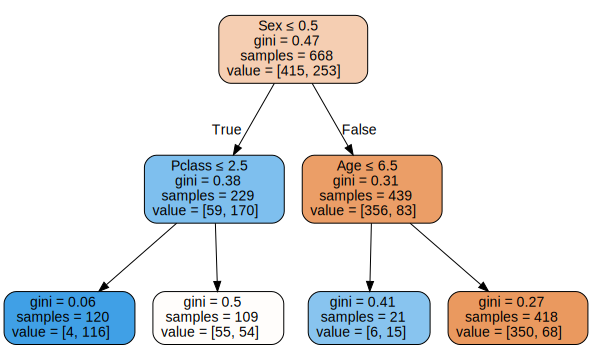

In [51]:
draw_tree(m, trn_xs, size=10)

Lets see how good the model is.

In [52]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

Given how small the dataset is, its basically the same. We try mode leaf nodes.

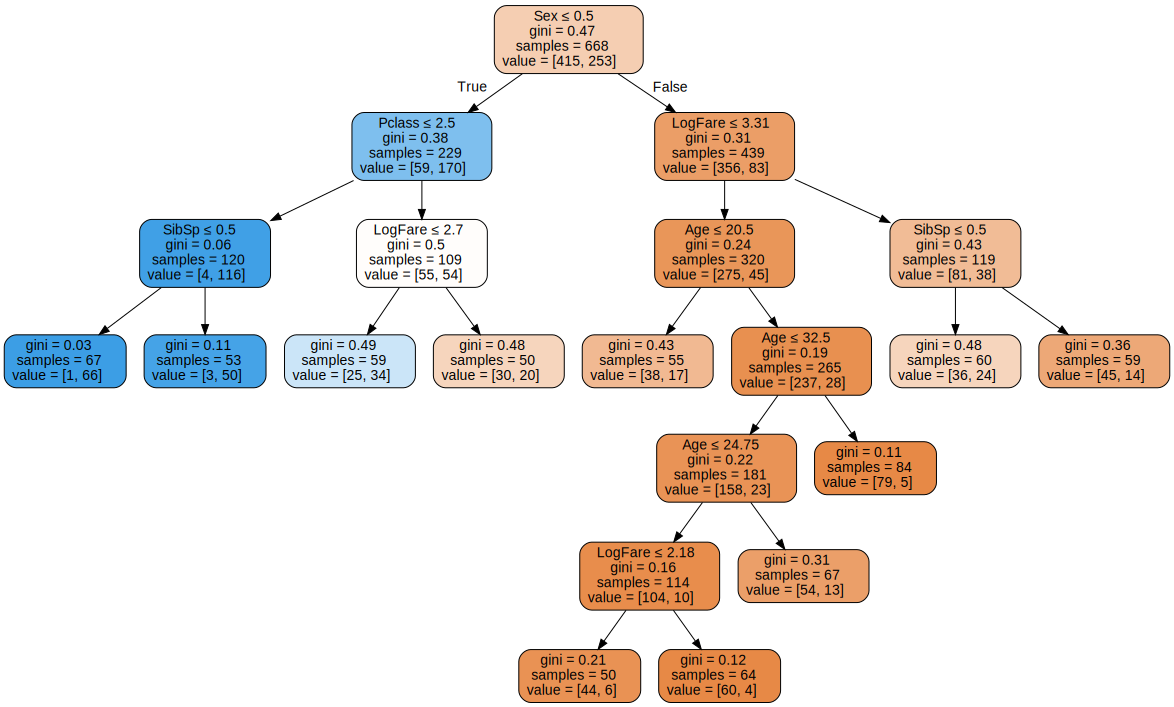

In [53]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=25)

In [54]:
mean_absolute_error(val_y, m.predict(val_xs))

0.18385650224215247

Much better!